In [39]:
import os
import numpy as np
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ruta = os.path.join('.', 'datos', 'PercMultAplicado.xlsx')
datos = pd.read_excel(ruta)

In [40]:
datos

,Entidad,Monto,Mensualidad,Plazo (años),Tasa anual,Ingreso mensual,Antigüedad laboral (meses),Mora
0,Sinaloa,299200,6277.86,20,0.25,33911.00,58,SI
1,Michoacán de Ocampo,281100,9373.58,20,0.40,112783.48,149,NO
2,Nuevo León,268800,8963.43,20,0.40,33186.96,134,NO
3,Guerrero,256600,9106.81,5,0.35,51118.90,77,NO
4,Yucatán,256500,5381.92,20,0.25,197168.90,5,SI
...,...,...,...,...,...,...,...,...
995,Baja California Sur,18700,473.05,15,0.30,2861.95,150,NO
996,Baja California,16600,416.11,20,0.30,3618.79,25,SI
997,Colima,16400,582.04,5,0.35,3770.64,107,NO
998,Morelos,14600,384.88,10,0.30,1751.91,60,NO


In [41]:
def limpieza_datos(d, salida, bool):
    """ 
    Homogeniza los nombres de las columnas en minísculas y convierte la variable de salida en booleana.

    Parámetros:
    ------------
    d: DataFrame
        DataFrame con los datos a limpiar.
    salida: string
        Nombre de la columna que contiene la variable de salida.
    bool: dict
        Diccionario con los valores a reemplazar en la columna de salida.

    Regresa:
    ------------
    d: DataFrame
        DataFrame con los datos limpios.
    """
    d.columns = d.columns.str.lower()
    d[f'{salida}_bool'] = d[salida].replace(bool)
    return d

In [42]:
# ------------------------ limpieza de datos ------------------------ #
D = limpieza_datos(datos, 'mora', {'SI': 1, 'NO': 0})
D['carga'] = D['mensualidad'] / D['ingreso mensual']
#D.rename(columns={'antigüedad laboral (meses)': 'antiguedad_laboral_meses'}, inplace=True)

subset = D[['monto', 'antigüedad laboral (meses)', 'carga', 'mora_bool']].to_numpy()

### Estandarización de datos

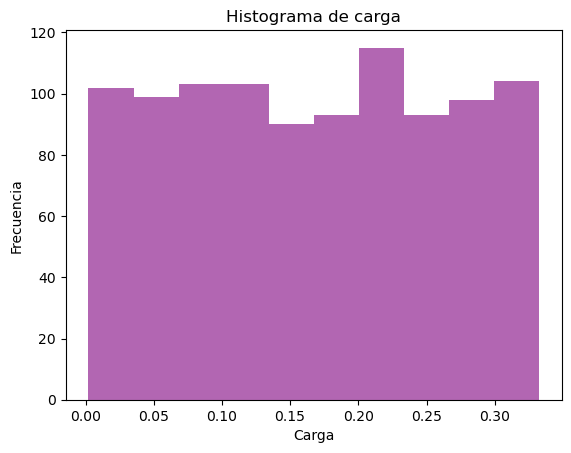

In [43]:
# columna 2: "carga"
plt.hist(subset[:,2], color='purple', alpha=0.6)
plt.title('Histograma de carga')
plt.xlabel('Carga')
plt.ylabel('Frecuencia')
plt.show()

In [44]:
print("mínimo:", subset[:,2].min(), "máximo:", subset[:,2].max())

mínimo: 0.0021474142693629914 máximo: 0.3327304085775127


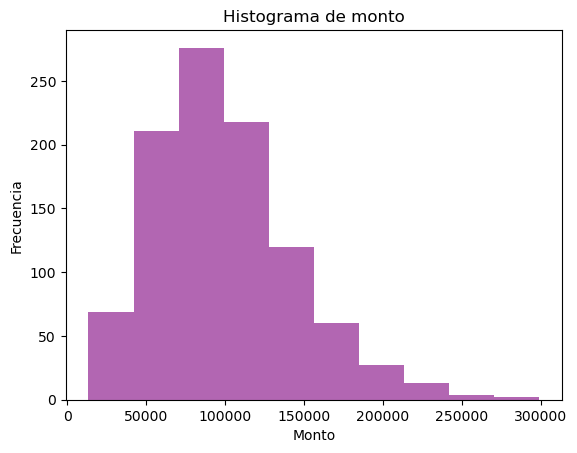

In [45]:
# columna 0: "monto"
plt.hist(subset[:,0], color='purple', alpha=0.6)
plt.title('Histograma de monto')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.show()

In [46]:
# calcula la raíz cuadrada
sqrt_c = np.sqrt(subset[:, 0]).reshape(-1, 1)
subset = np.hstack((subset, sqrt_c))

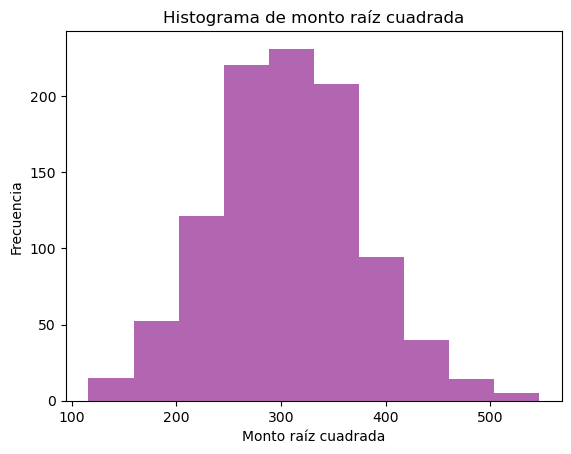

In [47]:
# columna 4: "raíz cuadrada de monto"
plt.hist(subset[:,4], color='purple', alpha=0.6)
plt.title('Histograma de monto raíz cuadrada')
plt.xlabel('Monto raíz cuadrada')
plt.ylabel('Frecuencia')
plt.show()

In [48]:
print("mínimo:", subset[:,4].min(), "máximo:", subset[:,4].max())

mínimo: 116.1895003862225 máximo: 546.9917732470938


In [49]:
# monto con min-max
monto_norm = (subset[:,4] - 100) / (600- 100)
subset = np.hstack((subset, monto_norm.reshape(-1, 1)))

In [50]:
print("mínimo:", subset[:,5].min(), "máximo:", subset[:,5].max())

mínimo: 0.03237900077244501 máximo: 0.8939835464941875


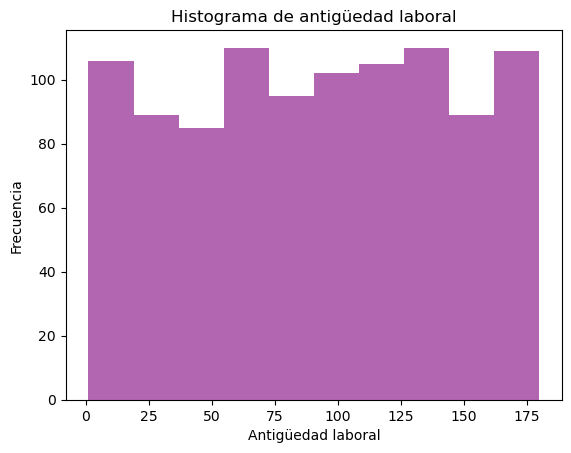

In [51]:
# columna 1: "antigüedad laboral (meses)"
plt.hist(subset[:,1], color='purple', alpha=0.6)
plt.title('Histograma de antigüedad laboral')
plt.xlabel('Antigüedad laboral')
plt.ylabel('Frecuencia')
plt.show()

In [52]:
# antiguedad_laboral_meses con min-max
al_norm = (subset[:,1] - 0) / (subset[:,1].max() - 0)
subset = np.hstack((subset, al_norm.reshape(-1, 1)))

In [53]:
print("mínimo:", subset[:,6].min(), "máximo:", subset[:,6].max())

mínimo: 0.005555555555555556 máximo: 1.0


In [54]:
# subset final normalizado
subset_norm = subset[:, [2, 5, 6, 3]]

### Proceso para generar los sets de entrenamiento y testeo

In [55]:
from generacion_sets import generar_sets_arr

# ------------------------ generación de sets ------------------------ #
train, test = generar_sets_arr(subset_norm, arr=subset_norm[:, 3], prop=0.7, prop_interna_f=0.8, prop_interna_t=0.2)

In [56]:
# ------------------------ información de los sets ------------------------ #
print("train:", train.shape)
print("test:", test.shape)

print("train 0:", np.sum(train[:, 3]), "test 0:", np.sum(test[:, 3]))
print("train 1:", train.shape[0] - np.sum(train[:, 3]), "test 1:", test.shape[0] - np.sum(test[:, 3]))

train: (700, 4)
test: (300, 4)
train 0: 140.0 test 0: 69.0
train 1: 560.0 test 1: 231.0


# Entrenamiento de la red neuronal

In [57]:
# -------------------- # Preparación de los datos # ---------------------- #
X = train[:, 0:3]
d = train[:, 3].reshape(-1, 1)

In [58]:
# ------------------------------ # Fase 1 # ------------------------------ #
# definiendo las dimensiones
N = X.shape[1]  #N es el número de entradas
L = 4 #  neuronas en la capa oculta
M = 1 #  neuronas en la capa de salida

# inicializando los pesos (de inicio, son aleatorios)
w_h = np.random.uniform(-1, 1, (L, N))
w_o = np.random.uniform(-1, 1, (M, L))

In [59]:
print(N, L, M)
print(w_h.shape)
print(w_o.shape)

3 4 1
(4, 3)
(1, 4)


In [60]:
from perceptron_multicapa import proceso_entrenamiento

# ------------------ # proceso de entrenamiento # -------------------- #
w_h, w_o = proceso_entrenamiento(X, d, w_h, w_o, Q=X.shape[0], alfa=0.05, precision=0.00001)

In [61]:
w_h

array([[-3.60702883,  1.05120117, -2.0816707 ],
       [-3.72376302,  1.14502917, -2.55174711],
       [ 4.06562133, -2.73223481,  4.45063694],
       [ 1.06292263,  0.52936013,  0.58062142]])

In [62]:
w_o

array([[ 5.25168578,  6.38298247, -6.32367534, -0.24349482]])

### Datos de entrenamiento

In [63]:
from perceptron_multicapa import proceso_funcionamiento

x_train = train[:, 0:3]
N = x_train.shape[1]

# ----------------- # Proceso de funcionamiento # ------------------- #
y_pred_train = proceso_funcionamiento(x_train, Q=x_train.shape[0], M=1, w_h=w_h, w_o=w_o)

In [64]:
# ----------------- # Evaluación del entrenamiento # ------------------- #

# juntar y_pred_train con subset_norm[:, 3]
y_pred_train = np.hstack((y_pred_train, train[:, 3].reshape(-1, 1)))

# generar un array de comparación con true/false
y_pred = pd.DataFrame(y_pred_train, columns=['y_pred', 'd'])

# comparar y_pred con d
y_pred['comparacion'] = y_pred.y_pred == y_pred.d

In [65]:
# ----------------- # Accuracy # ------------------- #
accuracy = y_pred.comparacion.sum() / y_pred.shape[0]
print("accuracy:", accuracy)

accuracy: 0.9785714285714285


### Datos de testeo

In [66]:
x_test = test[:, 0:3]
N = x_test.shape[1]
d_test = test[:, 3].reshape(-1, 1)

# ----------------- # Proceso de funcionamiento # ------------------- #
y_pred_test = proceso_funcionamiento(x_test, Q=x_test.shape[0], M=1, w_h=w_h, w_o=w_o)

In [67]:
# ----------------- # Evaluación del entrenamiento # ------------------- #

# juntar y_pred_test con subset_norm[:, 3]
y_pred_test = np.hstack((y_pred_test, d_test))

# generar un array de comparación con true/false
y_pred = pd.DataFrame(y_pred_test, columns=['y_pred', 'd'])

# comparar y_pred con d
y_pred['comparacion'] = y_pred.y_pred == y_pred.d

In [68]:
# ----------------- # Accuracy # ------------------- #
accuracy = y_pred.comparacion.sum() / y_pred.shape[0]
print("accuracy:", accuracy)

accuracy: 0.9833333333333333


### Graficar